In [23]:
# Importación de librerias.
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import os

# Carga del dataset. 
analogias_df = pd.read_csv('todas_respuestas_rango_1.csv')
analogias_df.head()

,Unnamed: 0,cueEjemplo,targetEjemplo,cue,response,count,rank,p
0,1,abogado,corte,doctor,hospital,58,1,0.651685
1,2,amigos,felicidad,jefe,trabajo,15,1,0.159574
2,3,árbol,hojas,flor,pétalos,67,1,0.644231
3,4,Argentina,Buenos_Aires,Brasil,Brasilia,87,1,0.906250
4,5,ave,ala,delfín,aleta,79,1,0.858696


In [2]:
embeddings_WIKI = KeyedVectors.load_word2vec_format('embeddings/wiki.es.vec', limit=None)
embeddings_SUC = KeyedVectors.load_word2vec_format('embeddings/embeddings-l-model.vec', limit=None)
embeddings_SWOW = KeyedVectors.load_word2vec_format('embeddings/swow.embedding.was.26-04-2022.vec', limit=None)
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
embeddings_SBWC = KeyedVectors.load_word2vec_format('embeddings/SBW-vectors-300-min5.txt', limit=None)
embeddings_Glove = KeyedVectors.load_word2vec_format('embeddings/glove-sbwc.i25.vec', limit=None)

In [3]:
# Embedding SWOW pasado a minusculas 

# Vectores y palabras del SWOW.
palabras = list(embeddings_SWOW.key_to_index.keys())
vectores = list(embeddings_SWOW.vectors)

# Convertir todas las palabras a minúsculas.
palabras_minusculas = [palabra.lower() for palabra in palabras]

# Creación de un nuevo modelo SWOW con las palabras y vectores en minúsculas. 
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
lower_embeddings_SWOW.add_vectors(palabras_minusculas, vectores)

In [4]:
lista_de_Embeddings = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove]

In [5]:
# Calculo de la frecuencia de las combinaciones de 'cue' y 'response' y sus rangos para identificar las analogías más relevantes
analogias_df['count'] = analogias_df.groupby(['cue','response'])['response'].transform('count')
analogias_df['rank'] = analogias_df.groupby('cue')['count'].rank(ascending=False, method='min')

# Calculo del porcentaje de frecuencia de cada combinación en relación con el número total de respuestas para ese 'cue'.
total_respuestas = analogias_df.groupby('cue')['response'].transform('count')
analogias_df['porcentaje'] = (analogias_df['count'] / total_respuestas) * 100

# Indices de filas que tienen rango minimo (rango 1).
idx = analogias_df.groupby(['cue'])['rank'].idxmin()

# Me quedo unicamente con las filas que tienen las combinaciones más relevantes según el rango.
analogias_df = analogias_df.loc[idx]

# Se guarda el DataFrame modificado en un archivo CSV.
analogias_df.to_csv('analogies_answers.csv', index=False)

# Se pasan todas las palabras a minúsculas. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].apply(lambda x: str(x).lower())
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].apply(lambda x: str(x).lower())
analogias_df['cue'] = analogias_df['cue'].apply(lambda x: str(x).lower())

# Se realizan los reemplazos necesarios. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['cue'] = analogias_df['cue'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')


## Filtrar: sólo las analogías que tengan todas las palabras en todos los embeddings

In [6]:
# Filtrar filas que tengan todas las palabras en todos los embeddings

# "all" combina los valores booleanos de word in e.key_to_index, para todos los embeddings e
# luego, se forma un valor para cada fila de cada una de las 4 columnas
columns = ['cueEjemplo', 'targetEjemplo','cue','response']
filtro = [ [ all(word in e.key_to_index  for e in lista_de_Embeddings) for word in analogias_df[column]] for column in columns]
# me quedo sólo con las que tienen todas las palabras en todos los embeddings
filtro = [a & b & c & d for a,b,c,d in zip(filtro[0],filtro[1],filtro[2],filtro[3])]

analogias_df = analogias_df[filtro]

## Calculo una vez las predicciones, K=25

In [7]:
from mis_funciones import metricas_topK, calcular_predicciones

K_fijo = 25
todas_predicciones = [calcular_predicciones(e, analogias_df, K_fijo) for e in lista_de_Embeddings] 
# es una lista de listas, cada lista en todas_predicciones contiene las predicciones generadas para cada embedding en específico
# Se itera sobre cada modelo de embedding (e) en lista_de_Embeddings y se llama a la función calcular_predicciones con ese modelo, el df analogias_df y el valor de K_fijo
# Se generan predicciones para cada fila en analogias_df utilizando el embedding 

### Pero luego calculo varios valores de K, simplemente recortando la lista de predicciones

In [8]:
# en base aun únic cálculo de predicciones, calcular las métricas para diferentes valores de K
Ks = [5, 10, 15, 20, 25]
topK_metricas = [[metricas_topK(prediccion, analogias_df,K)  for K in Ks] for prediccion in todas_predicciones]
# lista que almacena las métricas calculadas por metricas_topK para cada conjunto de predicciones en todas_predicciones
# Se itera sobre cada conjunto de predicciones en todas_predicciones y se llama a la función metricas_topK con ese conjunto de predicciones y el df analogias_df. 
# Se calcula la métrica de precisión top-K para cada conjunto de predicciones y devuelve una lista de estas métricas, cada valor representa la precisión top-K para un modelo de embedding específico
print(f"Métricas top-K ={Ks}: {topK_metricas}")


Métricas top-K =[5, 10, 15, 20, 25]: [[0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.05660377358490566], [0.03773584905660377, 0.07547169811320754, 0.09433962264150944, 0.11320754716981132, 0.1320754716981132], [0.05660377358490566, 0.1320754716981132, 0.1509433962264151, 0.24528301886792453, 0.3018867924528302], [0.05660377358490566, 0.07547169811320754, 0.09433962264150944, 0.09433962264150944, 0.11320754716981132], [0.09433962264150944, 0.18867924528301888, 0.22641509433962265, 0.2641509433962264, 0.2641509433962264]]


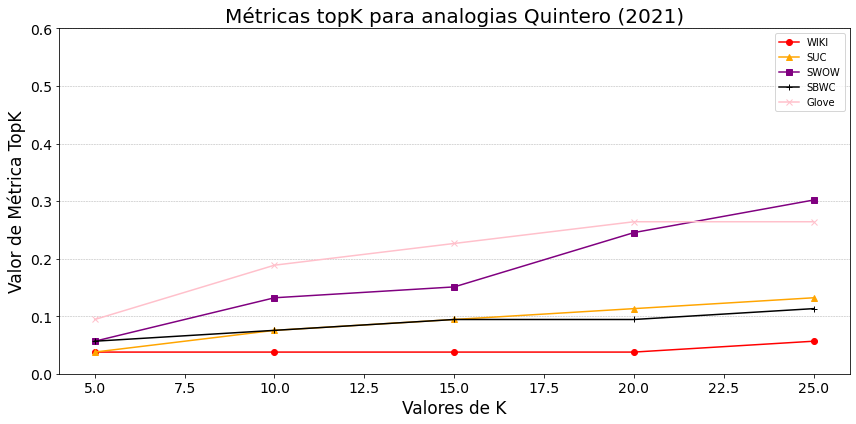

In [10]:
# Nombres de embeddings
lista_de_Nombres = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colores para plotear
colors = ['red', 'orange','purple', 'black', 'pink']

# marcadores para usar
markers = ['o', '^', 's','+','x']  # Markers for each category

# numero de embeddings
num_embeddings = len(lista_de_Nombres)

#width = 0.2

# Crear la figura para los datos del valor de K fijo
fig, ax = plt.subplots(figsize=(12, 6))

# valores de x para cada barra
x = np.arange(num_embeddings)

#bar = ax.bar(x, data_fijo, width, color='pink', edgecolor='black')
for i, emb in enumerate(lista_de_Nombres):
    plt.plot(Ks, topK_metricas[i], color=colors[i], label=lista_de_Nombres[i],marker=markers[i])

# Etiquetas 
ax.set_xlabel('Valores de K', fontsize=17)
ax.set_ylabel('Valor de Métrica TopK', fontsize=17)
ax.set_title(f'Métricas topK para analogias Quintero (2021)', fontsize=20)
#ax.set_xticks(x)
#ax.set_xticklabels(lista_de_Nombres, rotation=45, fontsize=12)

# Limitar el eje y entre 0 y .6
ax.set_ylim([0, .6])

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.legend()
plt.show()

## Bigger Analogy Test Set (BATS)

In [89]:
# Cargamos todos los archivos en una carpeta y los convertimo en DataFrames:
def cargar_archivos(carpeta):
    archivos = [os.path.join(carpeta, archivo) for archivo in os.listdir(carpeta) if archivo.endswith('.txt')]
    dfs = {}
    for archivo in archivos:
        print(f'Leyendo archivo: {archivo}')
        with open(archivo, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            # Crear un DataFrame
            df_categoria = pd.DataFrame([line.strip().split() for line in lines], columns=['cue', 'response'])
            # Almacenar el DataFrame en el diccionario
            nombre_archivo = os.path.basename(archivo)
            dfs[nombre_archivo] = df_categoria
    return dfs

# Carpeta donde se encuentran las subcarpetas de categorías las gramaticales del BATS (datos/bats/categorias)
carpeta_datos = 'datos' 
carpeta_bats = os.path.join(carpeta_datos, 'bats')

# Obtener la lista de las subcarpetas en la carpeta 'bats' (cada una de las categorias gramaticales)
categorias = [os.path.join(carpeta_bats, carpeta) for carpeta in os.listdir(carpeta_bats) if os.path.isdir(os.path.join(carpeta_bats, carpeta))]

# Inicializar un diccionario para almacenar los df de todas las categorías
dfs_todas_categorias = {}

# Iterar sobre cada subcarpeta de categoría y cargar los archivos como dataframes
for categoria in categorias:
    nombre_categoria = os.path.basename(categoria)
    print(f'Cargando archivos de la categoría: {nombre_categoria}')
    dfs_todas_categorias[nombre_categoria] = cargar_archivos(categoria)

# dfs_todas_categorias es un diccionario que contiene los df de todas las categorías gramaticales 

Cargando archivos de la categoría: derivational_morphology
Leyendo archivo: datos\bats\derivational_morphology\[re+verb_reg].txt
Leyendo archivo: datos\bats\derivational_morphology\[un+adj_reg].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+able_reg].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+er_irreg_femenino].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+er_irreg_masculino].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+ment_irreg].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+tion_irreg].txt
Cargando archivos de la categoría: encyclopedic_semantics
Leyendo archivo: datos\bats\encyclopedic_semantics\[animal - shelter].txt
Leyendo archivo: datos\bats\encyclopedic_semantics\[animal - sound].txt
Leyendo archivo: datos\bats\encyclopedic_semantics\[animal - young].txt
Leyendo archivo: datos\bats\encyclopedic_semantics\[country - capital].txt
Leyendo archivo: datos\bats\encyclopedic_semantics\[country - langua

### Analisis de derivational_morphology 

In [90]:
# Carpeta donde se encuentra la subcarpeta de derivational_morphology
carpeta_datos = 'datos'
carpeta_bats = os.path.join(carpeta_datos, 'bats')
carpeta_derivational = os.path.join(carpeta_bats, 'derivational_morphology')

# Cargar los archivos de la carpeta derivational_morphology como DataFrames
dfs_derivational_morphology = cargar_archivos(carpeta_derivational)


Leyendo archivo: datos\bats\derivational_morphology\[re+verb_reg].txt
Leyendo archivo: datos\bats\derivational_morphology\[un+adj_reg].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+able_reg].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+er_irreg_femenino].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+er_irreg_masculino].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+ment_irreg].txt
Leyendo archivo: datos\bats\derivational_morphology\[verb+tion_irreg].txt
{'[re+verb_reg].txt':             cue       response
0      adquirir     readquirir
1       ajustar      reajustar
2      aparecer     reaparecer
3       aplicar      reaplicar
4       nombrar      renombrar
5     organizar    reorganizar
6       evaluar      reevaluar
7       asignar      reasignar
8      asegurar     reasegurar
9      calcular     recalcular
10      conocer      reconocer
11   configurar   reconfigurar
12    confirmar    reconfirmar
13     conectar     re

In [104]:
# Función para calcular predicciones
def calcular_predicciones_bats(embedding, df, K_fijo):
    predicciones_bats = []
    palabras_no_encontradas = []
    for index, row in df.iterrows():
        cue = row['cue']
        try:
            resultado = embedding.most_similar(positive=[cue], topn=K_fijo)
            if resultado:
                predicciones_bats.append([palabra for palabra, _ in resultado])
            else:
                predicciones_bats.append([])
        except KeyError as e:
            print(f"Una de las palabras no está en el embedding: {e}")
            predicciones_bats.append([])
            palabras_no_encontradas.append(cue)
        except Exception as e:
            print(f"Error al procesar la palabra '{cue}': {e}")
            predicciones_bats.append([])
    return predicciones_bats, palabras_no_encontradas

# Función para calcular métricas top-K
def metricas_topK_bats(predicciones_bats, df, K):
    df['response'] = df['response'].fillna('').apply(lambda x: str(x).lower())
    topK_metricas_bats = []
    for i, prediccion in enumerate(predicciones_bats):
        respuesta_humana = df.iloc[i]['response']
        if prediccion:
            topK_metricas_bats.append(int(respuesta_humana in prediccion[0:K]))
        else:
            topK_metricas_bats.append(0)
    return np.mean(topK_metricas_bats)

K_fijo = 25
Ks = [5, 10, 15, 20, 25]

# diccionario para almacenar las métricas que se calcularon
resultados_metricas = {}

# Iterar sobre cada archivo en dfs_derivational_morphology
for nombre_archivo, df in dfs_derivational_morphology.items():
    print(f'Analizando archivo: {nombre_archivo}')
    todas_predicciones_bats = []
    palabras_no_encontradas_globales = []
    for embedding in lista_de_Embeddings:
        predicciones_bats, palabras_no_encontradas = calcular_predicciones_bats(embedding, df, K_fijo)
        todas_predicciones_bats.append(predicciones_bats)
        palabras_no_encontradas_globales.extend(palabras_no_encontradas)
    
    topK_metricas_bats = [[metricas_topK_bats(prediccion, df, K) for K in Ks] for prediccion in todas_predicciones_bats]
    
    resultados_metricas[nombre_archivo] = topK_metricas_bats
    print(f"Métricas top-K para {nombre_archivo} = {Ks}: {topK_metricas_bats}")
    print(f"Palabras no encontradas en {nombre_archivo}: {palabras_no_encontradas_globales}")


Analizando archivo: [re+verb_reg].txt
Una de las palabras no está en el embedding: "Key 'configurar' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'emerger' not present in vocabulary"
Una de las palabras no está en el embedding: "Key 'instalar' not present in vocabulary"
Métricas top-K para [re+verb_reg].txt = [5, 10, 15, 20, 25]: [[0.1794871794871795, 0.3333333333333333, 0.48717948717948717, 0.6410256410256411, 0.7692307692307693], [0.1282051282051282, 0.3333333333333333, 0.46153846153846156, 0.6153846153846154, 0.6153846153846154], [0.02564102564102564, 0.02564102564102564, 0.05128205128205128, 0.07692307692307693, 0.07692307692307693], [0.05128205128205128, 0.1282051282051282, 0.28205128205128205, 0.4358974358974359, 0.5128205128205128], [0.02564102564102564, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693, 0.07692307692307693]]
Palabras no encontradas en [re+verb_reg].txt: ['configurar', 'emerger', 'instalar']
Analizando archivo: [un+adj

Graficando resultados para [re+verb_reg].txt


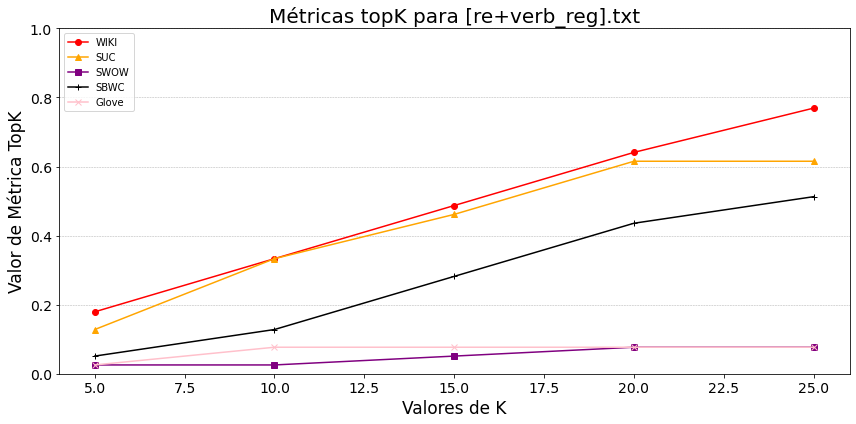

Graficando resultados para [un+adj_reg].txt


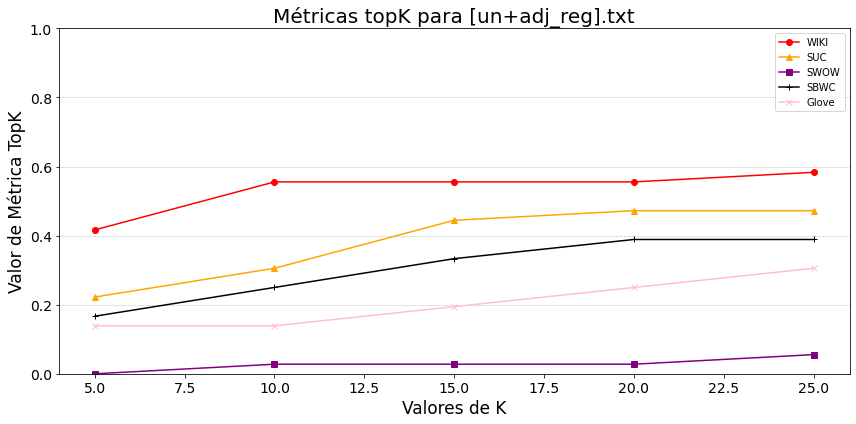

Graficando resultados para [verb+able_reg].txt


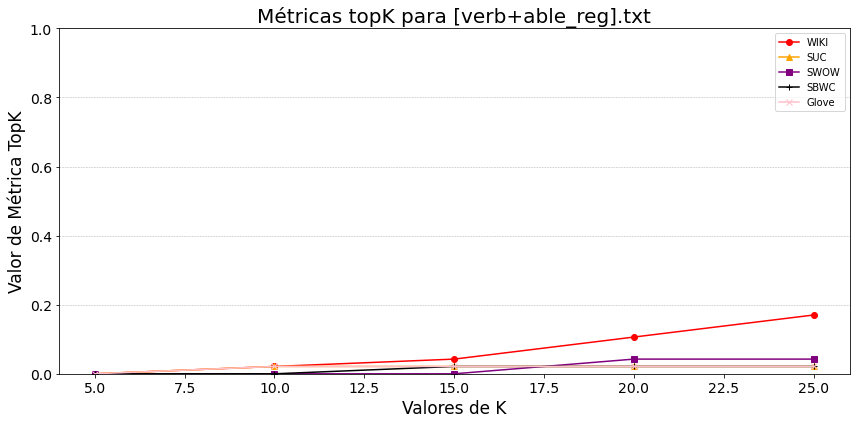

Graficando resultados para [verb+er_irreg_femenino].txt


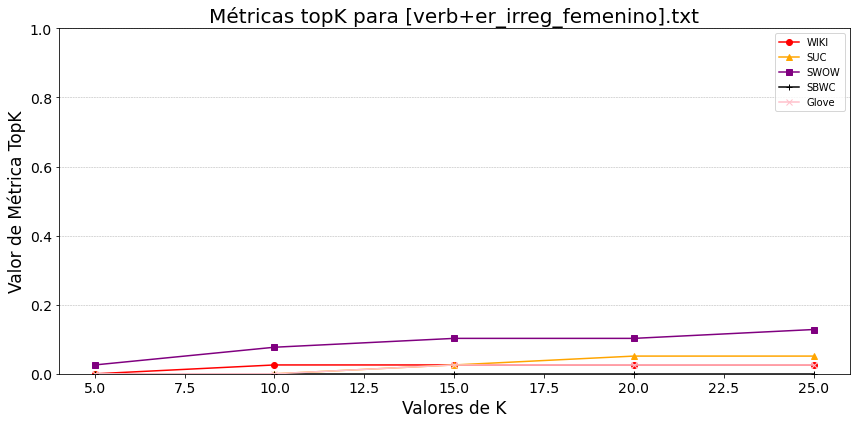

Graficando resultados para [verb+er_irreg_masculino].txt


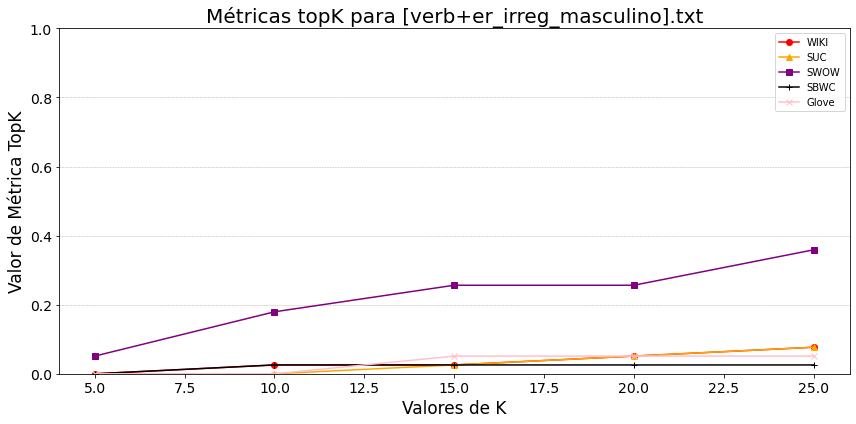

Graficando resultados para [verb+ment_irreg].txt


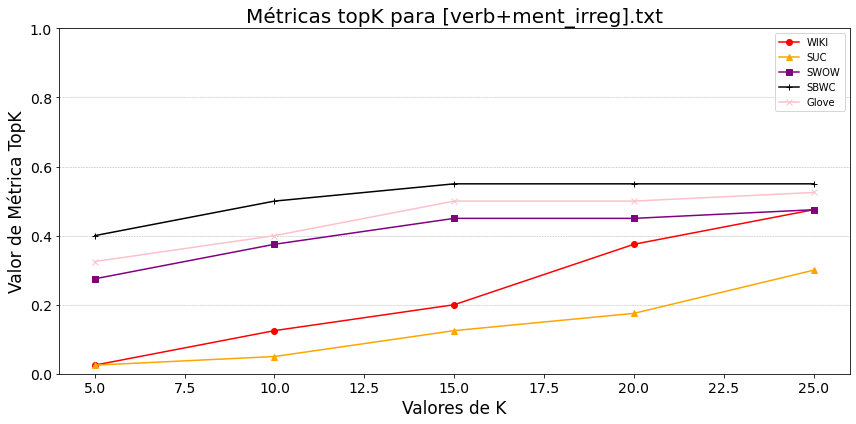

Graficando resultados para [verb+tion_irreg].txt


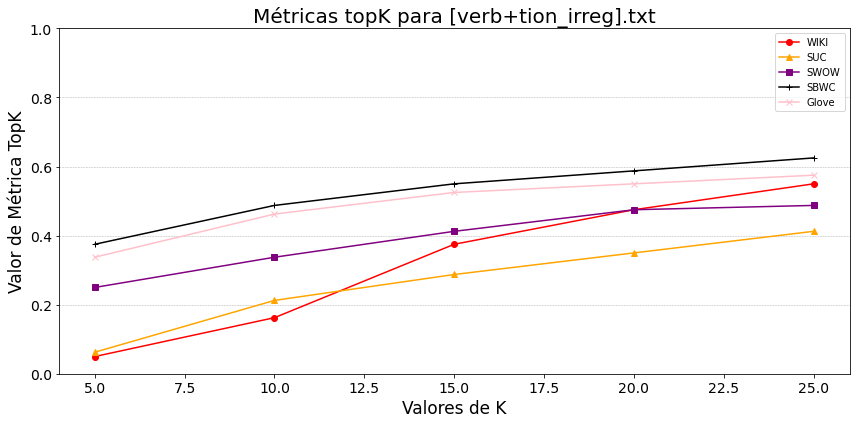

In [105]:
# nombres de embeddings
lista_de_Nombres = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# colores para plotear
colors = ['red', 'orange', 'purple', 'black', 'pink']

# Marcadores 
markers = ['o', '^', 's', '+', 'x']

# valores de K
Ks = [5, 10, 15, 20, 25]

# graficar los resultados que estan en resultados_metricas
for nombre_archivo, topK_metricas_bats in resultados_metricas.items():
    print(f'Graficando resultados para {nombre_archivo}')

    # Crear la grafica para los datos del valor de K fijo
    fig, ax = plt.subplots(figsize=(12, 6))

    # graficar las métricas top-K para cada embedding
    for i, emb in enumerate(lista_de_Nombres):
        plt.plot(Ks, topK_metricas_bats[i], color=colors[i], label=lista_de_Nombres[i], marker=markers[i])

    # Etiquetas
    ax.set_xlabel('Valores de K', fontsize=17)
    ax.set_ylabel('Valor de Métrica TopK', fontsize=17)
    ax.set_title(f'Métricas topK para {nombre_archivo}', fontsize=20)

    # limitar el eje y entre 0 y 1
    ax.set_ylim([0, 1])

    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.legend()
    plt.show()
